In [1]:
import warnings
warnings.filterwarnings("ignore")

### Import libraries

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn import neighbors, tree, linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

### Libraries for visualization
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import pyplot
import scikitplot as skplt

### Read the data and analyse

In [33]:
column_names= ['buying','maint','doors','persons','lug_boot','safety','rating']

In [34]:
df=pd.read_csv('car_evaluation.csv',names= column_names, index_col= False)
df.head()

,buying,maint,doors,persons,lug_boot,safety,rating
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [35]:
df.shape

(1728, 7)

In [36]:
df.isnull().values.any()
print(df.info())
print(df.describe())

Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   rating    1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
None
       buying  maint  doors persons lug_boot safety rating
count    1728   1728   1728    1728     1728   1728   1728
unique      4      4      4       3        3      3      4
top     vhigh  vhigh  5more       4      big    low  unacc
freq      432    432    432     576      576    576   1210


### Ordinal Encoding for the variables: buying, maint, lug_boot, safety

In [37]:
### Checking the count 
print("before:")
print('\nFor buying:\n')
print(df['buying'].value_counts())
print('\nFor maint:\n')
print(df['maint'].value_counts())
print('\nFor lug_boot:\n')
print(df['lug_boot'].value_counts())
print('\nFor safety:\n')
print(df['safety'].value_counts())
print('\nFor rating:\n')
print(df['rating'].value_counts())
print('\nFor doors:\n')
print(df['doors'].value_counts())
print('\nFor persons:\n')
print(df['persons'].value_counts())

before:

For buying:

vhigh    432
low      432
med      432
high     432
Name: buying, dtype: int64

For maint:

vhigh    432
low      432
med      432
high     432
Name: maint, dtype: int64

For lug_boot:

big      576
med      576
small    576
Name: lug_boot, dtype: int64

For safety:

low     576
med     576
high    576
Name: safety, dtype: int64

For rating:

unacc    1210
acc       384
good       69
vgood      65
Name: rating, dtype: int64

For doors:

5more    432
4        432
3        432
2        432
Name: doors, dtype: int64

For persons:

4       576
more    576
2       576
Name: persons, dtype: int64


In [38]:
level4_mapper = {"low":1, "med":2, "high":3, "vhigh":4}
lugboot_mapper = {"small":1, "med":2, "big":3}
safety_mapper = {"low":1, "med":2, "high":3}
df["buying_mapped"] = df["buying"].replace(level4_mapper)
df["maint_mapped"] = df["maint"].replace(level4_mapper)
df["lugboot_mapped"] = df["lug_boot"].replace(lugboot_mapper)
df["safety_mapped"] = df["safety"].replace(safety_mapper)

rating_mapper= {"unacc":1, "acc":2, "good":3, "vgood":4}
df["rating_mapped"] = df["rating"].replace(rating_mapper)

df.loc[df['doors'] == '5more', 'doors'] = 5
df.loc[df['persons'] == 'more', 'persons'] = 5

df.head()

,buying,maint,doors,persons,lug_boot,safety,rating,buying_mapped,maint_mapped,lugboot_mapped,safety_mapped,rating_mapped
0,vhigh,vhigh,2,2,small,low,unacc,4,4,1,1,1
1,vhigh,vhigh,2,2,small,med,unacc,4,4,1,2,1
2,vhigh,vhigh,2,2,small,high,unacc,4,4,1,3,1
3,vhigh,vhigh,2,2,med,low,unacc,4,4,2,1,1
4,vhigh,vhigh,2,2,med,med,unacc,4,4,2,2,1


In [39]:
### Retaining only the required columns for modelling exercise
df_model=df[['doors','persons','buying_mapped','maint_mapped','lugboot_mapped','safety_mapped','rating_mapped']]
df_model.head()

,doors,persons,buying_mapped,maint_mapped,lugboot_mapped,safety_mapped,rating_mapped
0,2,2,4,4,1,1,1
1,2,2,4,4,1,2,1
2,2,2,4,4,1,3,1
3,2,2,4,4,2,1,1
4,2,2,4,4,2,2,1


In [40]:
### Checking the count 
print("after:")
print('\nFor buying:\n')
print(df['buying_mapped'].value_counts())
print('\nFor maint:\n')
print(df['maint_mapped'].value_counts())
print('\nFor lug_boot:\n')
print(df['lugboot_mapped'].value_counts())
print('\nFor safety:\n')
print(df['safety_mapped'].value_counts())
print('\nFor rating:\n')
print(df['rating_mapped'].value_counts())
print('\nFor doors:\n')
print(df['doors'].value_counts())
print('\nFor persons:\n')
print(df['persons'].value_counts())

after:

For buying:

1    432
2    432
3    432
4    432
Name: buying_mapped, dtype: int64

For maint:

1    432
2    432
3    432
4    432
Name: maint_mapped, dtype: int64

For lug_boot:

1    576
2    576
3    576
Name: lugboot_mapped, dtype: int64

For safety:

1    576
2    576
3    576
Name: safety_mapped, dtype: int64

For rating:

1    1210
2     384
3      69
4      65
Name: rating_mapped, dtype: int64

For doors:

5    432
4    432
3    432
2    432
Name: doors, dtype: int64

For persons:

5    576
4    576
2    576
Name: persons, dtype: int64


In [41]:
### As per the data website there are no nulls in the dataset
### Ordinal mapping has been used instead of categorical variable conversion to retain the order
### Higher weight assigned to better ratings and vice versa

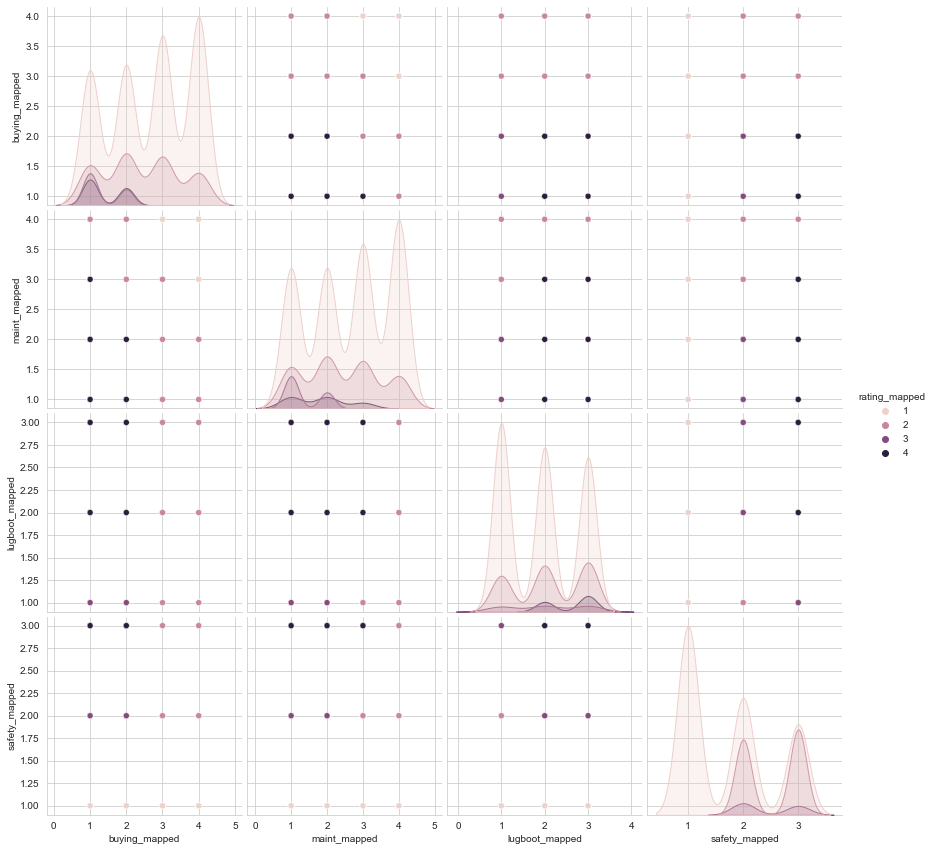

In [42]:
plt.close()
sns.set_style('whitegrid');
sns.pairplot(df_model, hue='rating_mapped', height=3);
plt.show()

## Training the models by nested CV for multi class classification

In [43]:
#create a dataframe with all training data except the target column
X = df_model.drop(columns=['rating_mapped'])
#check that the target variable has been removed
display(X.head())

#separate target values
y = df_model['rating_mapped'].values
#view target values
print("\n displaying target variable Y: ")
y[0:5]

,doors,persons,buying_mapped,maint_mapped,lugboot_mapped,safety_mapped
0,2,2,4,4,1,1
1,2,2,4,4,1,2
2,2,2,4,4,1,3
3,2,2,4,4,2,1
4,2,2,4,4,2,2



 displaying target variable Y: 


array([1, 1, 1, 1, 1], dtype=int64)

In [44]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                        random_state=1, stratify=y)

In [45]:
### Scaling the dataset
scaler = MinMaxScaler()
# transform data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print(X_train_scaled.shape, X_test_scaled.shape)

(1209, 6) (519, 6)


### KNN Multi class classifier

In [46]:
### Initializing grid for identifying best paramters
grid_params_knn= {'n_neighbors':range(5,20),
                  'weights':['uniform','distance'],
                  'metric':['euclidean','manhattan','minkowski']}
# KNN Classifier
model = KNeighborsClassifier()
NUM_TRIALS= 5
# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=i)
    outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model, param_grid=grid_params_knn, cv=inner_cv, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_train_scaled, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

In [47]:
### Model performance
score_difference = non_nested_scores - nested_scores
print(clf.best_params_)
print("Average non_nested_scores {0:6f} and average nested_scores {1:6f}."
      .format(non_nested_scores.mean(), nested_scores.mean()))
print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Average non_nested_scores 0.951696 and average nested_scores 0.946678.
Average difference of 0.005018 with std. dev. of 0.002624.


In [48]:
### Training the model based on hyperparameter tuning by grid search
clf_knn = KNeighborsClassifier(metric='manhattan', 
              n_neighbors=8, 
              weights='distance')
### using standardized data because using regularization
clf_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='distance')

In [49]:
### Fitting the model on the test data
y_test_hat=clf_knn.predict(X_test_scaled) 

Accuracy for the testing dataset with tuning is : 96.92%
F-Measure: 0.969
Recall: 0.969
Precision: 0.970
MCC: 0.933
Cohen's Kappa Score: 0.933

Test confusion_matrix
[[359   4   0   0]
 [  3 110   2   0]
 [  0   3  18   0]
 [  0   4   0  16]]


Text(34.0, 0.5, 'True')

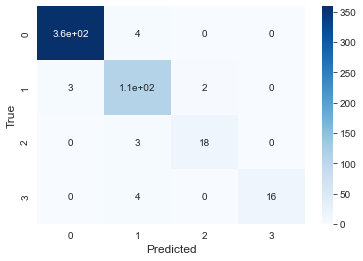

In [50]:
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for the testing dataset with tuning is : {:.2f}%".
      format(test_accuracy) )
test_fscore = f1_score(y_test, y_test_hat, average='weighted')
print('F-Measure: %.3f' % test_fscore)
test_recall = recall_score(y_test, y_test_hat, average='weighted')
print('Recall: %.3f' % test_recall)
test_precision = precision_score(y_test, y_test_hat, average='weighted')
print('Precision: %.3f' % test_precision)
cf_matrix = confusion_matrix(y_test, y_test_hat)
print("MCC: %.3f"% matthews_corrcoef(y_test, y_test_hat))
print("Cohen's Kappa Score: %.3f"% cohen_kappa_score(y_test, y_test_hat))
print("\nTest confusion_matrix")
print(cf_matrix)
sns.heatmap(cf_matrix, cmap='Blues', annot= True)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

### Logistic Regression multi class classifier

In [51]:
## using Grid Search CV
model = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial')
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

NUM_TRIALS= 5
# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=i)
    outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model, param_grid=space, cv=inner_cv, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_train_scaled, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

In [52]:
### Model performance
score_difference = non_nested_scores - nested_scores
print(clf.best_params_)
print("Average non_nested_scores {0:6f} and average nested_scores {1:6f}."
      .format(non_nested_scores.mean(), nested_scores.mean()))
print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

{'C': 100, 'penalty': 'l2'}
Average non_nested_scores 0.853874 and average nested_scores 0.853874.
Average difference of 0.000000 with std. dev. of 0.000000.


In [53]:
### Training the model based on hyperparameter tuning by grid search
clf3 = linear_model.LogisticRegression(C=100,solver ='lbfgs', multi_class='multinomial',
                                       penalty='l2')
### using standardized data because using regularization
clf3.fit(X_train_scaled, y_train)

LogisticRegression(C=100, multi_class='multinomial')

In [54]:
### Fitting the model on the test data
y_test_hat=clf3.predict(X_test_scaled) 

Accuracy for the testing dataset with tuning is : 84.39%
F-Measure: 0.839
Recall: 0.844
Precision: 0.837
MCC: 0.650
Cohen's Kappa Score: 0.648

Test confusion_matrix
[[341  21   1   0]
 [ 37  69   3   6]
 [  0  11  10   0]
 [  0   2   0  18]]


Text(34.0, 0.5, 'True')

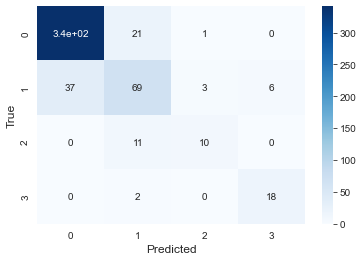

In [55]:
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for the testing dataset with tuning is : {:.2f}%".
      format(test_accuracy) )
test_fscore = f1_score(y_test, y_test_hat, average='weighted')
print('F-Measure: %.3f' % test_fscore)
test_recall = recall_score(y_test, y_test_hat, average='weighted')
print('Recall: %.3f' % test_recall)
test_precision = precision_score(y_test, y_test_hat, average='weighted')
print('Precision: %.3f' % test_precision)
cf_matrix = confusion_matrix(y_test, y_test_hat)
print("MCC: %.3f"% matthews_corrcoef(y_test, y_test_hat))
print("Cohen's Kappa Score: %.3f"% cohen_kappa_score(y_test, y_test_hat))
print("\nTest confusion_matrix")
print(cf_matrix)
sns.heatmap(cf_matrix, cmap='Blues', annot= True)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

### Decision tree multi class classifier

In [56]:
### Initializing grid for identifying best paramters
grid_params_dt= {'max_depth':range(2,5), 
                 'min_samples_leaf':range(1,5),
                 'min_samples_split':range(1,10),
                 'class_weight': ['balanced']}
# KNN Classifier
model = tree.DecisionTreeClassifier()
NUM_TRIALS= 5
# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=i)
    outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model, param_grid=grid_params_dt, cv=inner_cv, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_train_scaled, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

In [57]:
### Model performance
score_difference = non_nested_scores - nested_scores
print(clf.best_params_)
print("Average non_nested_scores {0:6f} and average nested_scores {1:6f}."
      .format(non_nested_scores.mean(), nested_scores.mean()))
print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

{'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Average non_nested_scores 0.746788 and average nested_scores 0.746788.
Average difference of 0.000000 with std. dev. of 0.000000.


In [58]:
### Training the model based on hyperparameter tuning by grid search
clf3 = tree.DecisionTreeClassifier(criterion='gini',
                                   max_depth=4,
                                   min_samples_leaf=1,
                                   min_samples_split=2,
                                   class_weight = 'balanced')
### using standardized data because using regularization
clf3.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4)

In [59]:
### Fitting the model on the test data
y_test_hat=clf3.predict(X_test_scaled) 

Accuracy for the testing dataset with tuning is : 72.25%
F-Measure: 0.761
Recall: 0.723
Precision: 0.859
MCC: 0.558
Cohen's Kappa Score: 0.524

Test confusion_matrix
[[266  43  31  23]
 [  0  69  30  16]
 [  0   0  20   1]
 [  0   0   0  20]]


Text(34.0, 0.5, 'True')

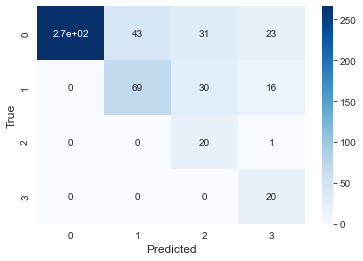

In [60]:
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for the testing dataset with tuning is : {:.2f}%".
      format(test_accuracy) )
test_fscore = f1_score(y_test, y_test_hat, average='weighted')
print('F-Measure: %.3f' % test_fscore)
test_recall = recall_score(y_test, y_test_hat, average='weighted')
print('Recall: %.3f' % test_recall)
test_precision = precision_score(y_test, y_test_hat, average='weighted')
print('Precision: %.3f' % test_precision)
cf_matrix = confusion_matrix(y_test, y_test_hat)
print("MCC: %.3f"% matthews_corrcoef(y_test, y_test_hat))
print("Cohen's Kappa Score: %.3f"% cohen_kappa_score(y_test, y_test_hat))
print("\nTest confusion_matrix")
print(cf_matrix)
sns.heatmap(cf_matrix, cmap='Blues', annot= True)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

### SVM classification for multi class classifier

In [ ]:
# Set up possible values of parameters to optimize over
p_grid = [{'kernel': ['rbf','poly'], 
           'gamma': [1e-3, 0.5, 1, 10],
           'C': [0.1, 1, 10]}]
# Support Vector Classifier
model = SVC()
NUM_TRIALS= 5
# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=i)
    outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_train_scaled, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()
    print(i)

In [62]:
### Training the model based on hyperparameter tuning by grid search
clf_svm = SVC(C=10,
              gamma= 1,
              kernel= 'rbf',)
### using standardized data because using regularization
clf_svm.fit(X_train_scaled, y_train)

### Fitting the model on the test data
y_test_hat=clf_svm.predict(X_test_scaled) 

Accuracy for the testing dataset with tuning is : 97.50%
F-Measure: 0.975
Recall: 0.975
Precision: 0.975
MCC: 0.945
Cohen's Kappa Score: 0.945

Test confusion_matrix
[[360   3   0   0]
 [  3 109   2   1]
 [  2   2  17   0]
 [  0   0   0  20]]


Text(34.0, 0.5, 'True')

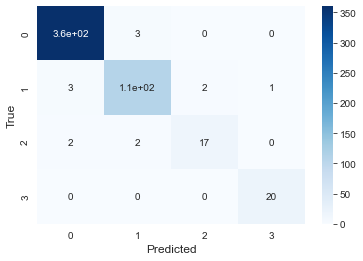

In [63]:
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for the testing dataset with tuning is : {:.2f}%".
      format(test_accuracy) )
test_fscore = f1_score(y_test, y_test_hat, average='weighted')
print('F-Measure: %.3f' % test_fscore)
test_recall = recall_score(y_test, y_test_hat, average='weighted')
print('Recall: %.3f' % test_recall)
test_precision = precision_score(y_test, y_test_hat, average='weighted')
print('Precision: %.3f' % test_precision)
cf_matrix = confusion_matrix(y_test, y_test_hat)
print("MCC: %.3f"% matthews_corrcoef(y_test, y_test_hat))
print("Cohen's Kappa Score: %.3f"% cohen_kappa_score(y_test, y_test_hat))
print("\nTest confusion_matrix")
print(cf_matrix)
sns.heatmap(cf_matrix, cmap='Blues', annot= True)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

### Summary of results

In [64]:
Results_test_data = {
    'Model Name':['SVM','Decision Tree','Logistic Regression','KNN'],
    'Accuracy' : ['97.5%','72.25%','84.39%','96.92%'],
    'F_Score' : ['0.975','0.761','0.839','0.969'],
    'Recall' : ['0.975','0.723','0.844','0.969'],
    'Precision' : ['0.975','0.859','0.837','0.970'],
    'MCC' : ['0.945','0.558','0.65','0.933'],
    'Cohens Kappa': ['0.945','0.524','0.648','0.933']
}

In [65]:
test_data_perf = pd.DataFrame(Results_test_data)
test_data_perf

,Model Name,Accuracy,F_Score,Recall,Precision,MCC,Cohens Kappa
0,SVM,97.5%,0.975,0.975,0.975,0.945,0.945
1,Decision Tree,72.25%,0.761,0.723,0.859,0.558,0.524
2,Logistic Regression,84.39%,0.839,0.844,0.837,0.65,0.648
3,KNN,96.92%,0.969,0.969,0.970,0.933,0.933


In [ ]:
### Bssed on the above results, it can be said that LNN and SVM are the best 
### performing becuase not only they have high accuracy but also high MCC and 
### Kappa. This leads to the conclusion that these models are able to 
### model the multiple classes effectively